In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [3]:
!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.8.1
Uninstalling nltk-3.8.1:
  Successfully uninstalled nltk-3.8.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.8 MB/s eta 0:00:00 0:00:01


In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import os
import shutil
import pandas as pd
# import sh
#from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from google.cloud import storage
import datetime


In [6]:
import pyspark
sc = spark.sparkContext

print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))
print('Original spark.driver.maxMemory: ' + sc._conf.get('spark.driver.memory'))

Original spark.driver.maxResultSize: 1920m
Original spark.driver.maxMemory: 3840m


In [7]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [8]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

In [ ]:
#bucket_name = "msca-bdp-tweets"
#folder_name = "final_project"
#list_blobs(bucket_name, folder_name)

In [ ]:
#twitter_raw = spark.read.json("gs://msca-bdp-tweets/final_project/")
#twitter_raw.limit(5)

In [ ]:
twitter_raw_full = spark.read.json("gs://msca-bdp-tweets/final_project/")

23/05/14 19:01:01 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
23/05/14 19:29:04 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Data Inspection

In [ ]:
twitter_sample = twitter_raw_full.sample(withReplacement=False, fraction=0.0001, seed=42).cache()

In [ ]:
del twitter_sample

In [15]:
twitter_sample.limit(5)

coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,withheld_in_countries
null,Tue May 24 21:32:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529213882518077443,1529213882518077443,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,EmmaKennedy,"{null, Tue May 24...","<a href=""http://t...",RT @EmmaKennedy: ...,1653427975669,false,"Hey America, when...","{false, Mon Jun 1...",null
null,Tue May 24 21:32:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529213886678740992,1529213886678740992,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,MadisonArm,"{null, Tue May 24...","<a href=""http://t...",RT @MadisonArm: G...,1653427976661,false,Grocery stores. E...,"{false, Wed Jun 0...",null
null,Tue May 24 21:32:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529213886926229504,1529213886926229504,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,Nullisecondus,"{null, Sat May 21...","<a href=""http://t...",RT @Nullisecondus...,1653427976720,false,Adigun Daniel is ...,"{false, Tue Apr 2...",null
null,Tue May 24 21:32:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529213899765055492,1529213899765055492,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,big_business_,"{null, Tue May 24...","<a href=""http://t...",RT @big_business_...,1653427979781,false,Elementary school...,"{false, Sun Feb 1...",null
null,Tue May 24 21:33:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529213903695409152,1529213903695409152,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,libsoftiktok,"{null, Thu May 19...","<a href=""https://...",RT @libsoftiktok:...,1653427980718,false,A parent in @olen...,"{false, Sat May 2...",null


In [44]:
print(twitter_sample.select('retweeted_status').first()[0])


Row(coordinates=None, created_at='Wed Jun 08 11:39:38 +0000 2022', display_text_range=[0, 140], entities=Row(hashtags=[], media=None, symbols=[], urls=[Row(display_url='twitter.com/i/web/status/1…', expanded_url='https://twitter.com/i/web/status/1534500393664888832', indices=[117, 140], url='https://t.co/e4ldSChww4')], user_mentions=[]), extended_entities=None, extended_tweet=Row(display_text_range=[0, 275], entities=Row(hashtags=[], media=[Row(additional_media_info=None, description=None, display_url='pic.twitter.com/MjJuNvyDjB', expanded_url='https://twitter.com/rapplerdotcom/status/1534500393664888832/photo/1', id=1534500391131439106, id_str='1534500391131439106', indices=[276, 299], media_url='http://pbs.twimg.com/media/FUuj-cEWYAI9p5e.jpg', media_url_https='https://pbs.twimg.com/media/FUuj-cEWYAI9p5e.jpg', sizes=Row(large=Row(h=800, resize='fit', w=800), medium=Row(h=800, resize='fit', w=800), small=Row(h=680, resize='fit', w=680), thumb=Row(h=150, resize='crop', w=150)), source_s

In [23]:
print(twitter_sample.select('user').first()[0])

Row(contributors_enabled=False, created_at='Mon Jun 15 10:48:11 +0000 2009', default_profile=True, default_profile_image=False, description='Freelance learning consultant new technologies. NCCE trainer, Seesaw ambassador, Purple Mash trainer, Edtech demonstrator. Lets get back in the EU NOW!!', favourites_count=13190, followers_count=638, friends_count=1032, geo_enabled=True, id=47308043, id_str='47308043', is_translator=False, listed_count=7, location='Suffolk', name='Brendan Routledge #FBPE #JOHNSONOUT', profile_background_color='C0DEED', profile_background_image_url='http://abs.twimg.com/images/themes/theme1/bg.png', profile_background_image_url_https='https://abs.twimg.com/images/themes/theme1/bg.png', profile_background_tile=False, profile_banner_url='https://pbs.twimg.com/profile_banners/47308043/1578225233', profile_image_url='http://pbs.twimg.com/profile_images/1497697238503632899/QUpF8NgG_normal.jpg', profile_image_url_https='https://pbs.twimg.com/profile_images/14976972385036

In [25]:
print(twitter_sample.select('entities').first()[0])

Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[Row(id=23217907, id_str='23217907', indices=[3, 15], name='Emma Kennedy💙', screen_name='EmmaKennedy')])


In [26]:
print(twitter_sample.select('tweet_text').first()[0])


Hey America, when we had a mass shooting in a school we massively clamped down on who could own a gun. Know how many mass shootings in schools we’ve had since? Zero. It’s ok to change laws to keep kids safe.


In [56]:
print(twitter_sample.select('created_at').first()[0])

Wed Jun 08 22:45:40 +0000 2022


In [27]:
Original_tweets = twitter_sample.select('retweeted').where(col('retweeted') != "RT").count()

In [28]:
print(Original_tweets)

101775


## Checking uniqueness of user id and user name

In [33]:
user_data = Edu_subset2.select('created_at','user_id', 'followers', 'user_name') \
                      .orderBy('user_id')

In [ ]:
user_data.take(40)

[Row(created_at='Thu Jul 28 04:20:01 +0000 2022', user_id=69053, followers=5151, user_name='Áine 🧙\u200d♀️\U0001fa84🧹⛧'),
 Row(created_at='Thu Aug 04 03:23:45 +0000 2022', user_id=678403, followers=39580, user_name='Lucy Gray 🌻🇺🇦'),
 Row(created_at='Fri Apr 08 18:31:41 +0000 2022', user_id=809309, followers=25062, user_name='Todd Finley'),
 Row(created_at='Mon Jan 23 15:26:33 +0000 2023', user_id=809309, followers=28840, user_name='Todd Finley'),
 Row(created_at='Sat Nov 19 18:46:06 +0000 2022', user_id=809309, followers=28520, user_name='Todd Finley'),
 Row(created_at='Sat Apr 16 20:32:56 +0000 2022', user_id=809309, followers=25349, user_name='Todd Finley'),
 Row(created_at='Tue Jan 17 02:30:14 +0000 2023', user_id=809309, followers=28772, user_name='Todd Finley'),
 Row(created_at='Wed Apr 13 02:12:20 +0000 2022', user_id=809309, followers=25160, user_name='Todd Finley'),
 Row(created_at='Wed May 18 04:10:59 +0000 2022', user_id=809309, followers=26094, user_name='Todd Finley'),
 Row

## Subset the data related to education, schools, universities, learning, and knowledge sharing.

In [32]:
twitter_sample = twitter_raw_full.sample(withReplacement=False, fraction=0.0000001, seed=42).cache()

In [33]:
twitter_sample = twitter_raw_full.limit(20)

11

In [26]:
Edu_subset2 = twitter_raw_full.select(
        'created_at', 
        F.col('id').alias('tweet_id'),
        F.col('user.id').alias('user_id'),
        F.col('user.name').alias('user_name'),
        F.col('user.description').alias('user_description'),
        F.col('user.followers_count').alias('followers'), 
        F.col('user.tweet_count').alias('user_tweet_total'), 
        F.col('user.listed_count').alias('user_lists'), 
        F.col('user.location').alias('user_location'), 
        F.col('entities').alias('entities'),
        F.col('entities.user_mentions').alias('mentions_g'),
        'tweet_text', 
        'retweeted', 
        'retweeted_from') \
    .select(
        'created_at', 
        'tweet_id',
        'user_name',
        'user_description',
        'user_id',
        'followers',
        'user_tweet_total',
        'user_lists'
        'user_location', 
        F.explode(F.col('entities.hashtags.text')).alias('hashtag'),
        'mentions_g',
        'tweet_text', 
        'retweeted', 
        'retweeted_from') \
    .where((F.col('lang') == 'en') & 
        F.col('hashtag').isin(['k12', 'highered', 'bookban', 'teachersunion', 'remoteteaching', 'remotelearning', 'schoolreopen'])
    )

In [27]:
Edu_subset2.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- followers: long (nullable = true)
 |-- user_location: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- mentions_g: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- retweeted_from: string (nullable = true)



In [29]:
Edu_subset2.take(3)

[Row(created_at='Tue May 24 20:43:06 +0000 2022', tweet_id=1529201344804016130, user_name='LTW', user_description='LTW is a leading systems integrator, specializing in network, wireless and security technologies and offering services across the entire project lifecycle.', user_id=1027083378, followers=1088, user_location='NJ, NY & PA', hashtag='k12', mentions_g=[Row(id=221209467, id_str='221209467', indices=[39, 45], name='Grapevine-Colleyville ISD', screen_name='GCISD'), Row(id=31006123, id_str='31006123', indices=[48, 58], name='Kyle Berger', screen_name='edtechcto')], tweet_text='With more than 20 years as a #k12 CTO, @GCISD’s @edtechcto knows a thing or two about network refreshes. Check out this interview for his do’s and don’ts. #edtech via @EdTech_K12 https://t.co/NgY8l1DA6H #LTWllc', retweeted='', retweeted_from='GCISD’s @edtechcto knows a thing or two about network refreshes. Check out… https'),
 Row(created_at='Tue May 24 23:16:26 +0000 2022', tweet_id=1529239933805899783, us

In [11]:
@F.pandas_udf(TimestampType())
def parse_datetime(created_at):
    return pd.to_datetime(created_at, format='%a %b %d %H:%M:%S +0000 %Y')

Twit_subset = Edu_subset2.select(
    parse_datetime(F.col('created_at')).alias('date_created'),
    'user_name', 'user_id',  'user_description', 'followers', 'user_location', 'hashtag','tweet_id', 
    'tweet_text', 'retweeted_from', 'mentions_g',
    F.when(Edu_subset2.retweeted == 'RT', 1).otherwise(0).alias('retweeted_encoded'))

Twit_subset.take(3)

[Row(date_created=datetime.datetime(2022, 8, 28, 1, 30, 11), user_name='RACHELLE DENÉ POTH | @ThriveinEDU #ARVR #AI', user_id=49860518, user_description='💥ISTE Certified Educator |Teacher| Consultant| Speaker| Attorney | Author Blogger  |Past-pres #ISTETEN | Buncee |Nearpod #PioNear| 💥#THRIVEinEDU 💜📚', followers=33206, user_location='Pittsburgh', hashtag='k12', tweet_id=1563700438846906369, tweet_text='New episodes  on my @ThriveinEDU podcast via @Rdene915 https://t.co/NRLIUSvb5F #education #teachertwitter #k12 #teacherPD #edtech #SEL #edleaders', retweeted_from='ThriveinEDU podcast via @Rdene915 https', mentions_g=[Row(id=1257066635371913217, id_str='1257066635371913217', indices=[20, 32], name='💥 ThriveinEDU Consulting #Edtech #AI #ARVR', screen_name='thriveinedu'), Row(id=49860518, id_str='49860518', indices=[45, 54], name='RACHELLE DENÉ POTH | @ThriveinEDU #ARVR #AI', screen_name='Rdene915')], retweeted_encoded=0),
 Row(date_created=datetime.datetime(2023, 1, 31, 12, 39, 2), user_n

In [12]:
Twit_subset.count()

13836

In [13]:
twit_sample = Twit_subset.sample(withReplacement=False, fraction=0.0723, seed=42).cache()

## Write the subsetted data to disk for later use

#### Saving cleaned data to disk for easy access later

In [3]:
#twit_sample.write.format('parquet').save('gs://msca-bdp-students-bucket/shared_data/imajumd0/twit_sample')

In [ ]:
twit_sample = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/imajumd0/twit_sample/")

In [13]:
twit_sample.printSchema()

root
 |-- date_created: timestamp (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_description: string (nullable = true)
 |-- followers: long (nullable = true)
 |-- user_location: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- mentions_g: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_encoded: integer (nullable = true)



#### Intermediary transformations

In [60]:
#drop fields not needed
Edu_expanded = Edu_expanded.withColumn("`entities.user_mentions[4]`", Edu_expanded["`entities.user_mentions[4]`"] \
                                        .dropFields("id_str")
                                        .dropFields("indices")
                                        .dropFields("screen_name"))

## Active Twitterers (based on volume of original content)

In [33]:
# filter where retweeted_from is None, groupby the user_name and count, orderby count of tweets
user_volume = twit_sample.select('user_name', 'user_id', 'user_description', 'retweeted_from') \
                         .where(F.col('retweeted_from').isNull()) \
                         .groupBy('user_name') \
                         .agg(F.count('user_id').alias('Num_original_tweets')) \
                         .orderBy(F.desc('Num_original_tweets'))

In [34]:
# Visualize the distribution of tweet  volume by Twitterers
user_volume.take(20)

[Row(user_name='AdjunctNation', Num_original_tweets=8),
 Row(user_name='Clark College Jobs', Num_original_tweets=6),
 Row(user_name='Adam Sanford', Num_original_tweets=5),
 Row(user_name='Dr. Karen Connaghan', Num_original_tweets=5),
 Row(user_name='David W. Deeds', Num_original_tweets=4),
 Row(user_name='Mjunaid', Num_original_tweets=4),
 Row(user_name='EdTech Breakthrough Awards', Num_original_tweets=4),
 Row(user_name='Nathalia Hardy', Num_original_tweets=4),
 Row(user_name='Clear Choice Prep', Num_original_tweets=4),
 Row(user_name='Trapped in Covid Ground Hog Day', Num_original_tweets=4),
 Row(user_name='Read Ahead AI', Num_original_tweets=4),
 Row(user_name='EdSurge HigherEd', Num_original_tweets=3),
 Row(user_name='Ohio School Boards', Num_original_tweets=3),
 Row(user_name='Accuracy in Academia', Num_original_tweets=3),
 Row(user_name='Ray Schroeder', Num_original_tweets=3),
 Row(user_name='Dr. SMAD', Num_original_tweets=3),
 Row(user_name='HPJR.2020', Num_original_tweets=3),
 

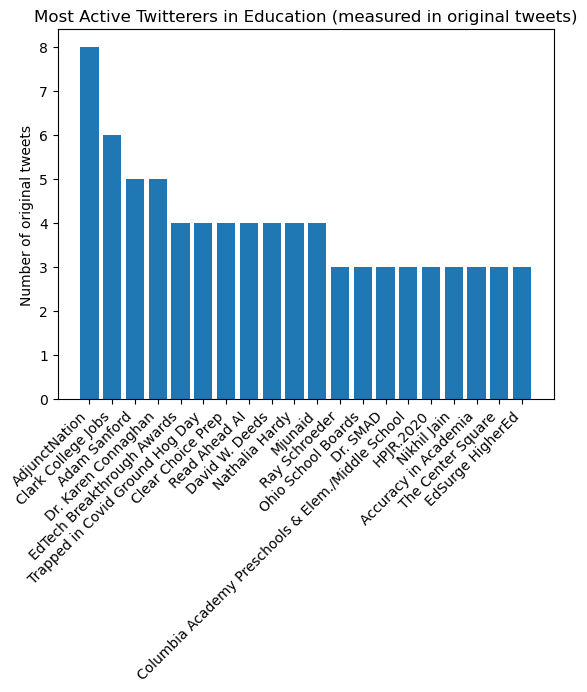

In [35]:
#plot of top 10 most active Twitterers in education
user_volume2 = user_volume.limit(20)
usernames = user_volume2.select('user_name').rdd.flatMap(lambda x: x).collect()
tweet_vol = user_volume2.select('Num_original_tweets').rdd.flatMap(lambda x: x).collect()

plt.bar(usernames, tweet_vol)
plt.xticks(rotation='45', ha='right')
plt.ylabel('Number of original tweets')
plt.title('Most Active Twitterers in Education (measured in original tweets)')
plt.show()

## Twitterers being retweeted the most
By message retweet (how often their messages are being retweeted). 

In [40]:
retweet_volume = twit_sample.select('user_name', 'user_id', 'user_description', 'tweet_id') \
                            .where(F.col('retweeted_encoded') == 1)

In [68]:
#Get the retweeted_status field from the original.
def expand_with_col(subsetted_data, original_data, col_to_add):
    original_data_sub = original_data.select(F.col('id'), F.col(col_to_add)).withColumnRenamed('id', 'tweet_id')
    joined_df = subsetted_data.join(original_data_sub, subsetted_data.tweet_id == original_data_sub.tweet_id, "inner")
    return joined_df

twit_sample_retweets10 = expand_with_col(twit_sample, twitter_raw_full, 'retweeted_status')


In [5]:
#twit_sample_retweets10.printSchema()

In [ ]:
# Get tweets that were retweeted but may have been missed in this subset of data
adl_retweets = twit_sample_retweets.select('retweeted_status') \
                                   .where(F.col('retweeted_from').isNotNull()) \
                                   .withColumnRenamed('retweeted_status.user.name', 'user_name') \
                                   .withColumnRenamed('retweeted_status.user.id', 'user_id') \
                                   .withColumnRenamed('retweeted_status.user.description', 'user_description') \
                                   .withColumnRenamed('retweeted_status.id', 'tweet_id') \

adl_retweets = twit_sample_retweets.select(F.explode('retweeted_status').alias('retweeted_status')) \
                                   .where(F.col('retweeted_from').isNotNull())

In [ ]:
adl_retweets.printSchema()

In [ ]:
adl_retweets2 = adl_retweets.select(col('retweeted_status.user.name').alias('user_name'),
                                    col('retweeted_status.user.id').alias('user_id'),
                                    col('retweeted_status.user.description').alias('user_description'),
                                    col('retweeted_status.id').alias('tweet_id'))

In [ ]:
#alternative to chatgpt
adl_retweets2 = adl_retweets.select(F.expr("retweeted_status['user']['name']").alias('user_name'),
                                    F.expr("retweeted_status['user']['id']").alias('user_id'),
                                    F.expr("retweeted_status['user']['description']").alias('user_description'),
                                    F.expr("retweeted_status['id']").alias('tweet_id'))

In [ ]:
#append retweet_volume and adl_retweets
combined_df = retweet_volume.unionAll(adl_retweets).distinct(['tweet_id'])
total_retweets = combined_df.groupBy('user_name') \
                            .agg(F.count('user_id').alias('Num_original_tweets')) \
                            .orderBy(F.desc('Num_original_tweets')) \
                            .limit(20)

In [ ]:
# Visualize the distribution of retweets by Twitterers
total_retweets2 = total_retweets.limit(20)
usernames = total_retweets2.select('user_name').rdd.flatMap(lambda x: x).collect()
retweet_vol = total_retweets2.select('Num_original_tweets').rdd.flatMap(lambda x: x).collect()

plt.bar(usernames, retweet_vol)
plt.xticks(rotation='45', ha='right')
plt.ylabel('Number of retweets')
plt.title('Most Retweeted Twitterers in Education')
plt.show()

In [ ]:
#retweet vs orginal tweet pi chart - overall

In [ ]:
#create a new column for the org_type
# create the user-tweet_count df
def expand_with_col(subsetted_data, original_data, col_to_add):
    original_data_sub = original_data.select(F.col('id'), F.col(col_to_add)).withColumnRenamed('id', 'tweet_id')
    joined_df = subsetted_data.join(original_data_sub, subsetted_data.tweet_id == original_data_sub.tweet_id, "inner")
    return joined_df

twit_sample_tweet_counts = expand_with_col(twit_sample, twitter_raw_full, 'user')

In [52]:
twit_sample_v2 = twit_sample_tweet_counts.withColumn('org_type', F.col('user.verified_type')) \
                                         .withColumn('listed_count', F.col('user.listed_count')) \
                                         .withColumn('tweets_total', F.col('user.statuses_count'))

In [53]:
# Group the DataFrame by 'group' and calculate the counts of retweets and originals
group_counts = twit_sample_v2.groupBy('org_type').agg(
    F.count(F.when(F.col('retweeted_from').isNotNull(), 1)).alias('retweets_count'),
    F.count(F.when(F.col('retweeted_from').isNull(), 1)).alias('originals_count')
    ).select('org_type', 'retweets_count', 'originals_count').orderBy('org_type').cache()


In [54]:
group_counts.show()

+--------+--------------+---------------+
|org_type|retweets_count|originals_count|
+--------+--------------+---------------+
|    null|           582|            213|
|    blue|           194|             26|
+--------+--------------+---------------+



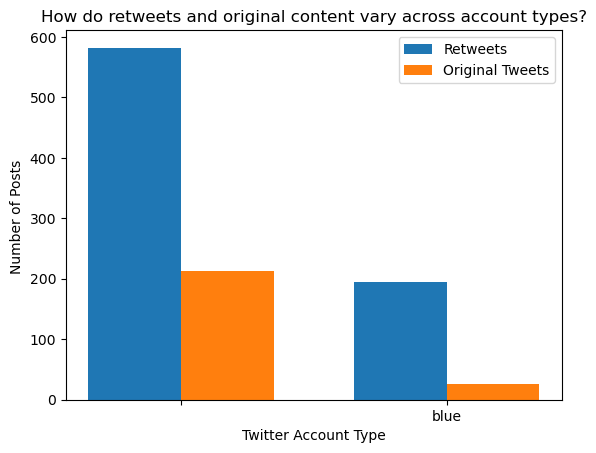

In [56]:
# Extract the group labels and counts
org_type = group_counts.select('org_type').rdd.flatMap(lambda x: x).collect()
retweets_counts = group_counts.select('retweets_count').rdd.flatMap(lambda x: x).collect()
originals_counts = group_counts.select('originals_count').rdd.flatMap(lambda x: x).collect()

bar_width = 0.35
x = np.arange(len(org_type))
fig, ax = plt.subplots()
rects1 = ax.bar(x - bar_width/2, retweets_counts, bar_width, label='Retweets')
rects2 = ax.bar(x + bar_width/2, originals_counts, bar_width, label='Original Tweets')

# Add labels, title, and legend
ax.set_xlabel('Twitter Account Type')
ax.set_ylabel('Number of Posts ')
ax.set_title('How do retweets and original content vary across account types?')
ax.set_xticks(x)
ax.set_xticklabels(org_type)
ax.legend()
plt.show()

In [60]:
twit_sample_v2.count()

1015

In [59]:
org_type

[None, 'blue']

####
By Types of Organizations

In [ ]:
# Visualize the distribution of tweets &  retweet volume by Twitterers and types of organizations

## Who are the top 10 most activer Twitterers in Education? 

In [ ]:
# Are users with the most followers the ones who are retweeted the most?
# Find the list of top 20 users by followers. Find the user > retweets mapping. Do an inner join. 
# Chart with one bars for retweets, and another for followers. sort by followers.

In [34]:
# Twit_sample replace with twit_subset
user_follower = twit_sample.select('date_created', 'user_name') \
                           .groupBy(F.col('user_name').alias('unique_user')) \
                           .agg(F.max('date_created').alias('most_recent_date')) \
                           .join(twit_sample, (twit_sample['user_name'] == F.col('unique_user')) & (twit_sample['date_created'] == F.col('most_recent_date'))) \
                           .select('user_name', 'followers') \
                           .orderBy(F.desc('followers'))

In [28]:
user_follower.take(20)

[Row(user_name='EdTech K–12 Magazine', followers=191903),
 Row(user_name='EdSurge', followers=159342),
 Row(user_name='Teaching STEM', followers=109288),
 Row(user_name='Emily Hewertson', followers=107176),
 Row(user_name='The Education Trust', followers=99246),
 Row(user_name='𝙎𝙝𝙚𝙡𝙡𝙮 𝙎𝙖𝙣𝙘𝙝𝙚𝙯 💡', followers=80886),
 Row(user_name='𝗧𝗖𝗘𝗔 ✈ 11 Days til #TCEA23', followers=77564),
 Row(user_name='𝗧𝗖𝗘𝗔', followers=77413),
 Row(user_name='Lori Lite', followers=66505),
 Row(user_name='New America', followers=56618),
 Row(user_name='Raymond Norman', followers=52076),
 Row(user_name='Scott McLeod', followers=51519),
 Row(user_name='edtech digest', followers=43152),
 Row(user_name='Paul Solarz', followers=41975),
 Row(user_name='The Trucker Vote', followers=38444),
 Row(user_name='Evan Robb', followers=38275),
 Row(user_name="James Minter, children's author", followers=36661),
 Row(user_name='Education Writers Association', followers=35550),
 Row(user_name='PRSA Jobcenter', followers=34614),
 Row

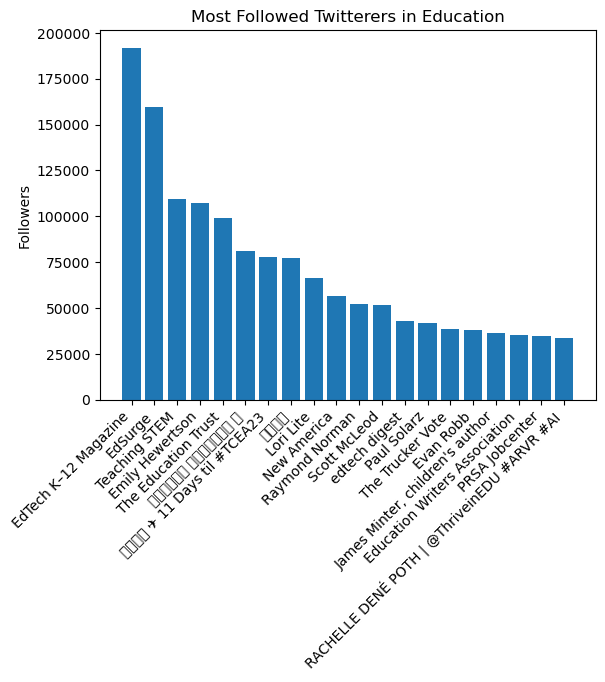

In [35]:
#plot of top 10 most followed Twitterers in education
top_followed = user_follower.limit(20)
usernames = top_followed.select('user_name').rdd.flatMap(lambda x: x).collect()
followers = top_followed.select('followers').rdd.flatMap(lambda x: x).collect()

plt.bar(usernames, followers)
plt.xticks(rotation='45', ha='right')
plt.ylabel('Followers')
plt.title('Most Followed Twitterers in Education')
plt.show()

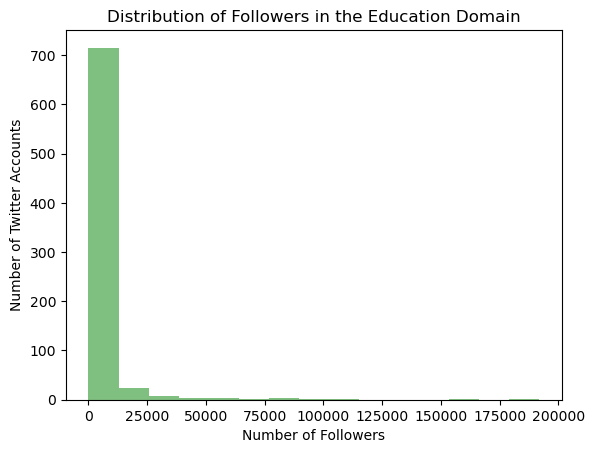

In [38]:
# distribution of followers across the dataset
followers2 = user_follower.select('followers').rdd.flatMap(lambda x: x).collect()

plt.hist(followers2, bins=15, alpha=0.5, color='green')
plt.ylabel('Number of Twitter Accounts')
plt.xlabel('Number of Followers')
plt.title('Distribution of Followers in the Education Domain')
plt.show()

In [39]:
start = twit_sample.select('date_created').agg(F.min('date_created'))
end = twit_sample.select('date_created').agg(F.max('date_created'))
print(f"Begin Date: {start}")
print(f"End Date: {end}")

Begin Date: +-------------------+
|  min(date_created)|
+-------------------+
|2022-04-05 09:30:00|
+-------------------+



End Date: +-------------------+
|  max(date_created)|
+-------------------+
|2023-02-25 07:08:07|
+-------------------+



## Who gets @mentioned? ####
Plotting mentions against user activity (i.e. tweet count)

In [42]:
twit_sample.printSchema()

root
 |-- date_created: timestamp (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_description: string (nullable = true)
 |-- followers: long (nullable = true)
 |-- user_location: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- mentions_g: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_encoded: integer (nullable = true)



In [15]:
# Explode the 'mentions_g.name' array column in the 'twit_sample' DataFrame
mentions = twit_sample.select(F.explode('mentions_g.name').alias('mention_name'))

# Group the mention names in the 'mentions' DataFrame and count the occurrences
users_mentions = mentions.groupBy('mention_name').count().withColumnRenamed('count', 'Number of mentions')

# Show the resulting mention counts
users_mentions.show()

+--------------------+------------------+
|        mention_name|Number of mentions|
+--------------------+------------------+
|         James Stroh|                 2|
|  The New York Times|                 1|
|Complete College ...|                 2|
|Georgina Dean 🏆 ...|                 1|
|            𝗧𝗖𝗘𝗔|               132|
|          Kate Jones|                 1|
|          Anne Kress|                 1|
|Hope Center for C...|                 1|
|Education Writers...|                 4|
|      Kevin Corcoran|                 1|
|     Scott Pulsipher|                 1|
|             eWaraqa|                 4|
|        Philip Evans|                 1|
|            Maggie B|                 1|
|Squarehead Teachers |                 7|
|      Lois McWhorter|                 1|
|          Astro_Afro|                 1|
|         Chris Davis|                 2|
|            U.S. GAO|                 1|
|Dr. Kristopher J....|                 1|
+--------------------+-----------------

In [41]:
# create the user-tweet_count df
def expand_with_col(subsetted_data, original_data, col_to_add):
    original_data_sub = original_data.select(F.col('id'), F.col(col_to_add)).withColumnRenamed('id', 'tweet_id')
    joined_df = subsetted_data.join(original_data_sub, subsetted_data.tweet_id == original_data_sub.tweet_id, "inner")
    return joined_df

twit_sample_tweet_counts = expand_with_col(twit_sample, twitter_raw_full, 'user')

In [17]:
#extract the most recent tweet_count for the user                                 
users_activity = twit_sample_tweet_counts.select('date_created', 'user_name') \
                           .groupBy(F.col('user_name').alias('unique_user')) \
                           .agg(F.max('date_created').alias('most_recent_date')) \
                           .join(twit_sample_tweet_counts, (twit_sample_tweet_counts['user_name'] == F.col('unique_user')) & (twit_sample_tweet_counts['date_created'] == F.col('most_recent_date'))) \
                           .select('user_name', F.col('user')["statuses_count"].alias("tweet_count"))   


In [ ]:
users_activity.take(5)

[Row(user_name='The Diversity Dashboard', tweet_count=57547),
 Row(user_name='Mr. Hilbert', tweet_count=21637),
 Row(user_name='California Competes', tweet_count=3798),
 Row(user_name='John Tuck', tweet_count=8611),
 Row(user_name='Christine Coc', tweet_count=603)]

In [18]:
# join the above dfs
mention_activity = users_mentions.join(users_activity, (users_activity['user_name'] == F.col('mention_name'))) \
                           .select('mention_name', 'Number of mentions', users_activity['tweet_count']) \
                           .orderBy(F.desc('Number of mentions'))

#took time to produce all mentions and tweet counts 
#in a graph - should I just show the top 

In [39]:
mention_activity.take(5)

[Row(mention_name='Todd Finley', Number of mentions=146, tweet_count=20501),
 Row(mention_name='𝗧𝗖𝗘𝗔', Number of mentions=132, tweet_count=35975),
 Row(mention_name='RACHELLE DENÉ POTH | @ThriveinEDU #ARVR #AI', Number of mentions=62, tweet_count=206402),
 Row(mention_name='Paul Solarz', Number of mentions=4, tweet_count=69495),
 Row(mention_name='Lori Lite', Number of mentions=4, tweet_count=305889)]

In [28]:
mention_activity = mention_activity.drop(F.col('Decile_mentions'))
mention_activity.printSchema()

root
 |-- mention_name: string (nullable = true)
 |-- Number of mentions: long (nullable = false)
 |-- tweet_count: long (nullable = true)



In [29]:
from pyspark.ml.feature import QuantileDiscretizer

# Apply QuantileDiscretizer to create buckets based on 'Number of mentions'
qds = QuantileDiscretizer(numBuckets=10,
                          inputCol='Number of mentions',
                          outputCol='Decile_mentions', exclusive = True)

mention_activity = qds.fit(mention_activity).transform(mention_activity)

# Perform grouping and aggregation
mention_activity_grouped = mention_activity.select('Decile_mentions', 'tweet_count') \
                                           .groupBy('Decile_mentions') \
                                           .agg(F.avg('tweet_count').alias('avg_tweet_count')) \
                                           .orderBy('Decile_mentions')


23/05/14 21:56:02 WARN org.apache.spark.ml.feature.QuantileDiscretizer: Some quantiles were identical. Bucketing to 4 buckets as a result.


In [33]:
mention_activity_grouped['Decile_mentions'].limit(3)

TypeError: 'Column' object is not callable

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [ ]:
mention_activity_grouped = mention_activity_grouped.cache()

In [ ]:
mention_activity_grouped.take(20)

KeyboardInterrupt: 

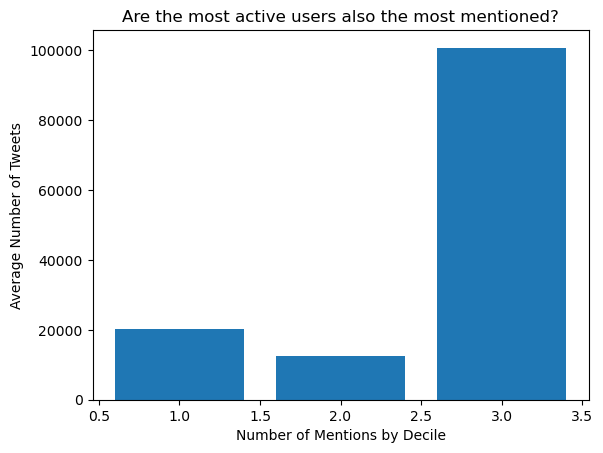

In [31]:
mentions_deciles_list = mention_activity_grouped.select('Decile_mentions').rdd.flatMap(lambda x: x).collect()
tweet_count_list = mention_activity_grouped.select('avg_tweet_count').rdd.flatMap(lambda x: x).collect()

plt.bar(mentions_deciles_list, tweet_count_list)
plt.title('Are the most active users also the most mentioned?')
plt.xlabel('Number of Mentions by Quartile')
plt.ylabel('Average Number of Tweets')
plt.show()

#### How are mentions distributed by organization type? 

In [ ]:
# user >> number of mentions >> organization type
user_mentions 

In [ ]:
# segments users into 4 groups, government, businesses, verified ind, others

In [ ]:
# for each segment, avg daily mentions? group by date created and avg

In [ ]:
# for each segment, how are mentions moving over time. x value : time, y axis: mentions 
# Assume you have data for each group in separate lists or arrays
#reformat the date 
group1_dates = ['2022-01-01', '2022-01-02', '2022-01-03', ...]
gov_mentions = [10, 12, 15, ...]

group2_dates = ['2022-01-01', '2022-01-02', '2022-01-03', ...]
bus_mentions = [8, 11, 14, ...]

group3_dates = ['2022-01-01', '2022-01-02', '2022-01-03', ...]
verind_mentions = [9, 13, 16, ...]

group4_dates = ['2022-01-01', '2022-01-02', '2022-01-03', ...]
nonver_mentions = [11, 9, 12, ...]

plt.plot(group1_dates, gov_mentions, label='Governments', color='red')
plt.plot(group2_dates, bus_mentions, label='Business', color='blue')
plt.plot(group3_dates, verind_mentions, label='Verified Individuals', color='green')
plt.plot(group4_dates, nonver_mentions, label='Non-verified', color='orange')

plt.xlabel('Date')
plt.ylabel('Average Daily Mentions')
plt.xticks(group1_dates[::14])
plt.title('Average Daily Mentions by Type of Account')
plt.legend()
plt.show()

## Spikes in activity after events

## Spikes in geography after events

## Who drives momentum after an event? Large-following accounts or the masses? 

## What does momentum for a non-event, e.g. criticalracetheory, look like? ####
Is this pattern different than date-driven events?